In [101]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import math 
import tensorflow as tf 
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import random 
from yahoo_fin import stock_info as si

In [316]:
ticker = "TSLA"
df = si.get_data(ticker)


In [317]:
df.head()

,open,high,low,close,adjclose,volume,ticker
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,TSLA
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,TSLA
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,TSLA
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,TSLA
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,TSLA


In [318]:
open_prices = df['open']
close_prices = df['close']
volumes = df['volume']
high_prices = df['high']
low_prices = df['low']
DATA_LEN = 300


close_prices = close_prices[len(close_prices) - 249:len(close_prices)].to_list()
open_prices = open_prices[len(open_prices) - 249:len(open_prices)].to_list()
volumes = volumes[len(volumes) - 249:len(volumes)].to_list()
high_prices = high_prices[len(high_prices) - 249:len(high_prices)].to_list()
low_prices = low_prices[len(low_prices) - 249:len(low_prices)].to_list()

In [319]:
plt.style.use('dark_background')

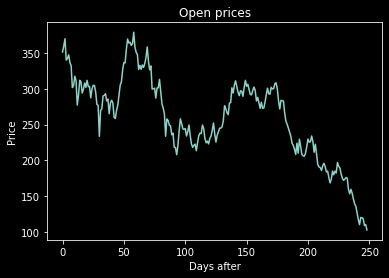

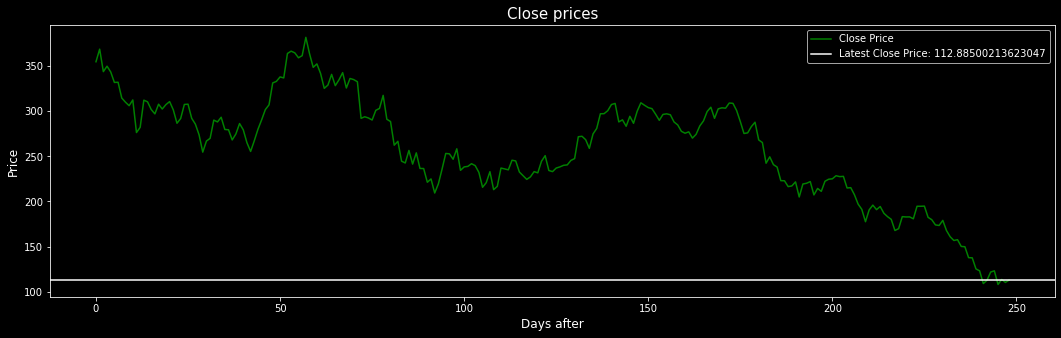

In [320]:
plt.title("Open prices")
plt.xlabel("Days after")
plt.ylabel("Price")
plt.plot(open_prices)
plt.show()


plt.figure(figsize=(18, 5))
plt.title("Close prices", fontsize=15)
plt.xlabel("Days after", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.plot(close_prices, 'g', label='Close Price')
plt.axhline(y=close_prices[len(close_prices) - 1], label=f'Latest Close Price: {close_prices[len(close_prices) - 1]}')
plt.legend()
plt.savefig("graphed-results/close-price")
plt.show()

In [321]:
len(close_prices)

249

In [322]:
close_for_calc = df['close']
close_for_calc = close_for_calc[len(close_for_calc) - 249:len(close_for_calc)]

## Applying indicators to predict the general trend of the stock 

## First Metric :- Relative Strength Index (RSI) 

Equation to compute the RSI of a stock 
RSI = 100 – (100 / [1 +RS])

Resource :- https://www.wallstreetmojo.com/relative-strength-index/

### Start

In [323]:
import pandas_ta as pta
relative_strength_indexs = pta.rsi(close_for_calc, length = 14)
relative_strength_indexs = relative_strength_indexs.to_list()

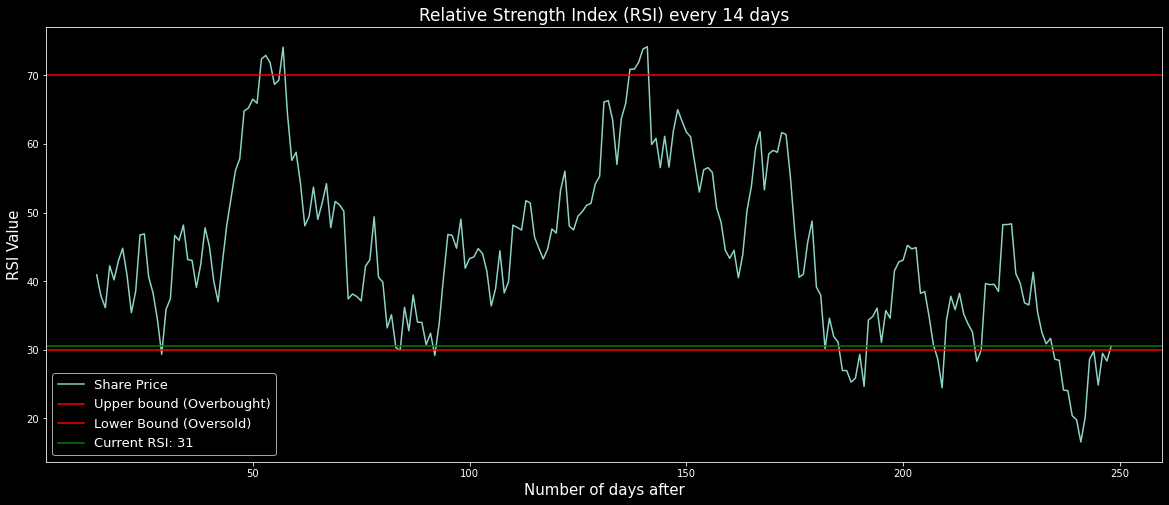

In [324]:
import matplotlib.pyplot as plt 
# %matplotlib notebook

plt.figure(figsize=(20, 8))
# plt.figure(figsize=(10, 5)) # This is when matplotlib notebook is activated
plt.plot(relative_strength_indexs, label='Share Price')
plt.axhline(y=70, color='r', label='Upper bound (Overbought)')
plt.axhline(y=30, color='r', label='Lower Bound (Oversold)')
plt.axhline(y=relative_strength_indexs[-1], color='g', label=f'Current RSI: {round(relative_strength_indexs[-1])}')
plt.title("Relative Strength Index (RSI) every 14 days", fontsize=17)
plt.xlabel("Number of days after", fontsize=15)
plt.ylabel("RSI Value", fontsize=15)
plt.legend(prop = {'size' : 13})
plt.savefig("graphed-results/RSI")
plt.show()

### End

## Creating Bollinger Bands

Simple Moving Average Equation + std 2

### start

In [325]:
import statistics

close_avg = close_for_calc.rolling(5).mean().to_list()
standard_deviations = close_for_calc.rolling(5).std().to_list()

upper_bollinger_band = []
lower_bollinger_band = []

for i in range(len(standard_deviations)):
    upper_bound = close_avg[i] + (standard_deviations[i] * 2)
    lower_bound = close_avg[i] - (standard_deviations[i] * 2)
    
    upper_bollinger_band.append(upper_bound)
    lower_bollinger_band.append(lower_bound)

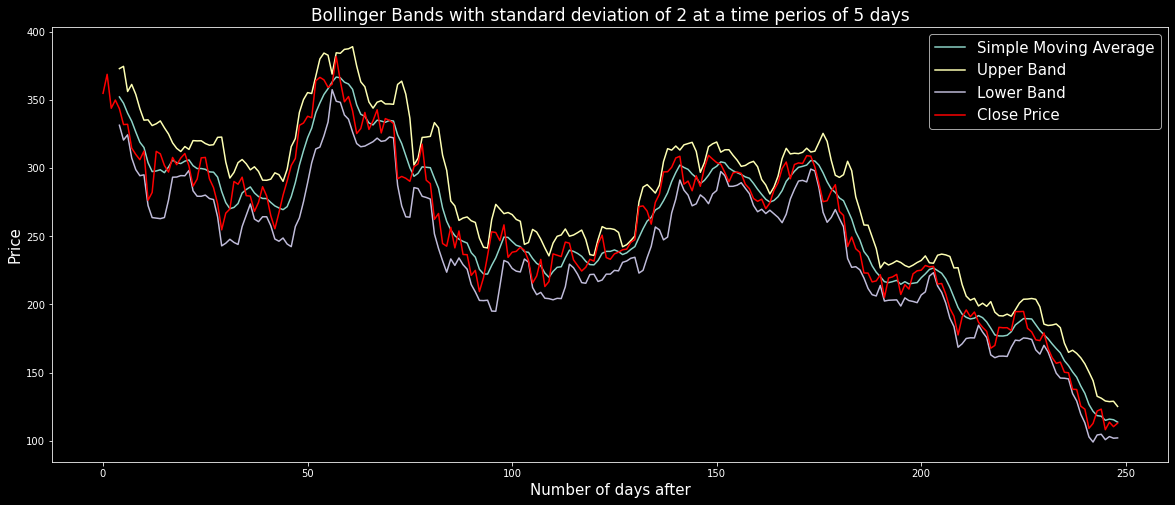

In [326]:
import matplotlib.pyplot as plt 


# Uncomment for interactive graphs
# %matplotlib notebook

plt.figure(figsize=(20, 8))
plt.plot(close_avg, label='Simple Moving Average')
plt.plot(upper_bollinger_band, label='Upper Band')
plt.plot(lower_bollinger_band, label='Lower Band')
plt.plot(close_prices, 'r', label='Close Price')
plt.title("Bollinger Bands with standard deviation of 2 at a time perios of 5 days", fontsize=17)
plt.xlabel("Number of days after", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.legend(prop = {'size' : 15})
plt.savefig("graphed-results/SMA + Bollinger Bands")
plt.show()

### end

## OBV :- On Balance Volume

In [327]:
on_balance_volumes = []
obv = 0

on_balance_volumes.append(obv)

for i in range(1, len(volumes)):
    if close_prices[i] > close_prices[i - 1]:
        obv += volumes[i]
        on_balance_volumes.append(obv)
        
    elif close_prices[i] < close_prices[i - 1]:
        obv -= volumes[i]
        on_balance_volumes.append(obv)
        
    else:
        obv += 0
        on_balance_volumes.append(obv)   
    

In [328]:
NUM_OF_DAYS_2 = 5
obv_df = pd.DataFrame(on_balance_volumes)
obv_sma = obv_df.rolling(NUM_OF_DAYS_2).mean()

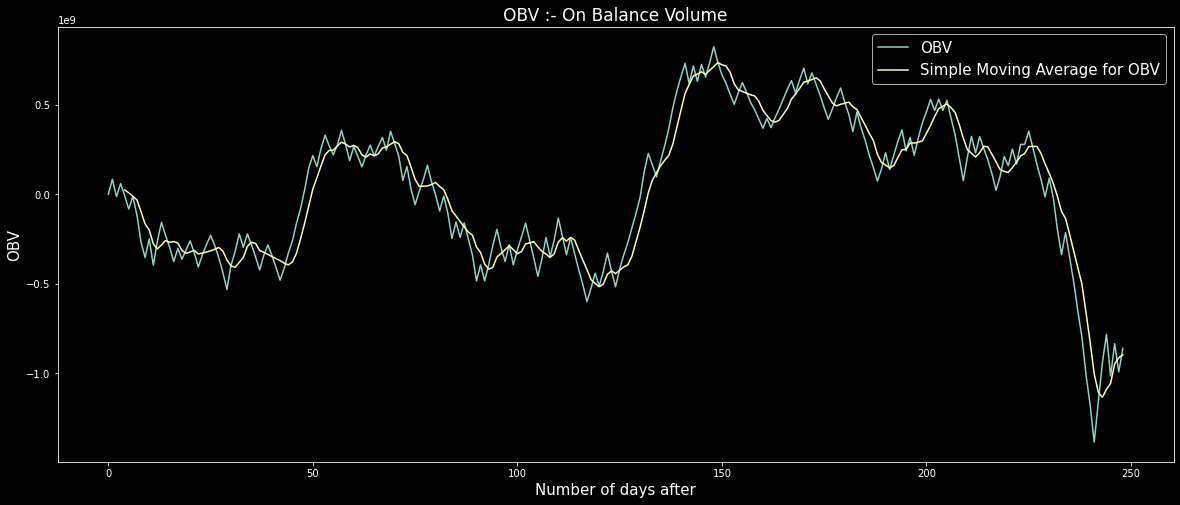

In [329]:
plt.figure(figsize=(20, 8))
plt.plot(on_balance_volumes, label='OBV')
plt.plot(obv_sma, label='Simple Moving Average for OBV')
plt.title("OBV :- On Balance Volume", fontsize=17)
plt.xlabel("Number of days after", fontsize=15)
plt.ylabel("OBV", fontsize=15)
plt.legend(prop = {'size' : 15})
plt.savefig("graphed-results/SMA(OBV) + OBV")
plt.show()

## Implementing MACD (Moving Average Convergence Divergence)

### Equation for MACD 
MACD=12-Period EMA − 26-Period EMA

In [330]:
ema12 = close_for_calc.ewm(span=12, adjust=False).mean()
ema26 = close_for_calc.ewm(span=26, adjust=False).mean()

macd = ema12 - ema26

# Signal line of macd
signal = macd.ewm(span=9, adjust=False).mean()

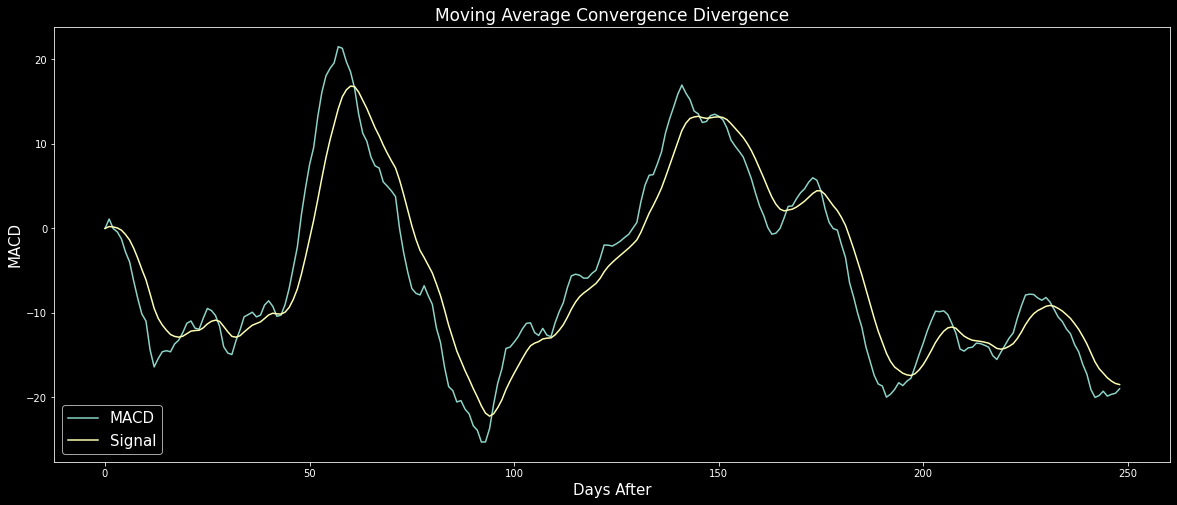

In [331]:
plt.figure(figsize=(20, 8))
plt.plot(macd.to_list(), label='MACD')
plt.plot(signal.to_list(), label='Signal')
plt.title("Moving Average Convergence Divergence", fontsize=17)
plt.ylabel("MACD", fontsize=15)
plt.xlabel("Days After", fontsize=15)
plt.legend(prop = {'size' : 15}, loc = 'lower left')
plt.savefig("graphed-results/MACD")
plt.show()

## Momentum

In [332]:
MOMENTUM_PERIOD = 10

momentum_values = []
for i in range(MOMENTUM_PERIOD, len(close_prices)):
    curr_close_price = close_prices[i]
    period_start_close_price = close_prices[i - MOMENTUM_PERIOD]
    momentum_values.append(curr_close_price - (period_start_close_price))

In [333]:
# Computing the average mometum 

momentum_sum = 0
for i in range(len(momentum_values)):
    momentum_sum += momentum_values[i]


avg_momentum = momentum_sum / len(momentum_values)

print(avg_momentum)

-9.18506957497058


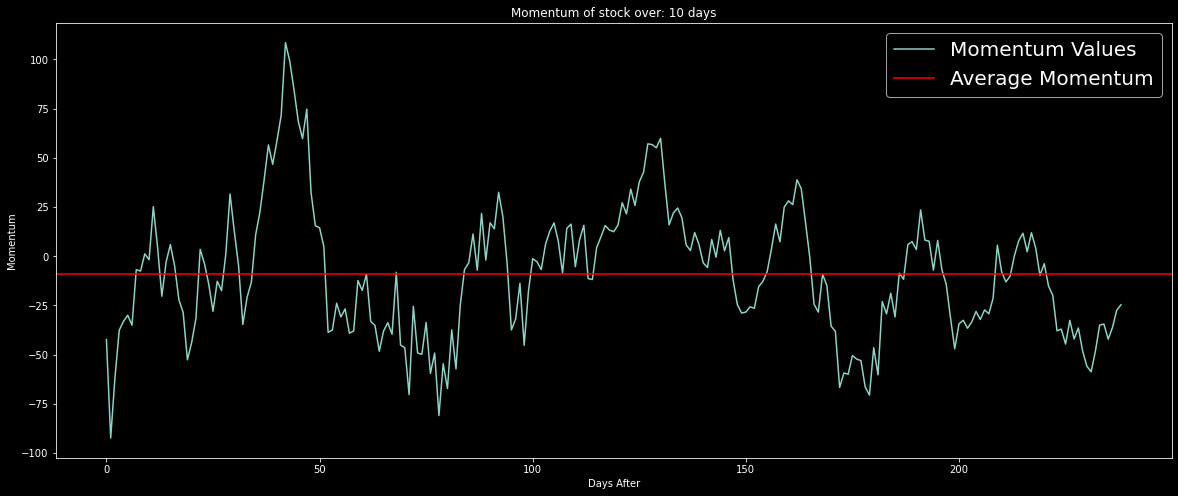

In [334]:
plt.figure(figsize=(20, 8))
plt.plot(momentum_values, label='Momentum Values')
plt.axhline(y=avg_momentum, label='Average Momentum', color='r')
plt.title(f"Momentum of stock over: {MOMENTUM_PERIOD} days")
plt.ylabel("Momentum")
plt.xlabel("Days After")
plt.legend(prop={'size':20})
plt.savefig("graphed-results/momentum")
plt.show()


## Resistance and Support Lines

In [335]:
type(close_prices)

list

### Computing the pivots Using the equation Pivot Point = (Previous Session High + Previous Session Low + Previous Session Close)/3

In [336]:
pivot_points = []

for i in range(len(close_for_calc)):
    if i == 0:
        pivot_points.append(float("nan"))
    else:
        prev_high = high_prices[i-1]
        prev_low = low_prices[i-1]
        prev_close = close_prices[i-1]
        
        pivot_point = (prev_high + prev_low + prev_close) / 3
        pivot_points.append(pivot_point)

### Computing the Resistance and Support levels using the equations below -


##### Resistance Level 1 = (2 x Pivot Point) – Previous Session Low
##### Support Level 1 – (2 x Pivot Point) – Previous High
##### Resistance Level 2 = (Pivot Point – Support Level 1) + Resistance Level 1 
##### Support Level 2 = Pivot Point – (Resistance Level 1 – Support Level 1) 
##### Resistance Level 3 = (Pivot Point – Support Level 2) + Resistance Level 2 
##### Support Level 3 = Pivot Point – (Resistance Level 2 – Support Level 2) 

In [337]:
resistance_1 = []
support_1 = []
resistance_2 = []
support_2 = []


for i in range(len(pivot_points)):
    if i == 0:
        resistance_1.append(float("nan"))
        support_1.append(float("nan"))
    else:
        r1 = (2 * pivot_points[i]) - low_prices[i-1]
        s1 = (2 * pivot_points[i]) - high_prices[i-1]
        
        r2 = (pivot_points[i] - s1) + r1
        s2 = pivot_points[i] - (r1 - s1)
        
        resistance_1.append(r1)
        support_1.append(s1)
        resistance_2.append(r2)
        support_2.append(s2)

In [338]:
print(type(support_1))
print(len(close_prices))

<class 'list'>
249


In [339]:
first_support_cross_counter = 0 

for i in range(len(support_1)):
    if support_1[i] > close_prices[i]:
        first_support_cross_counter += 1
        
        
print(first_support_cross_counter)

73


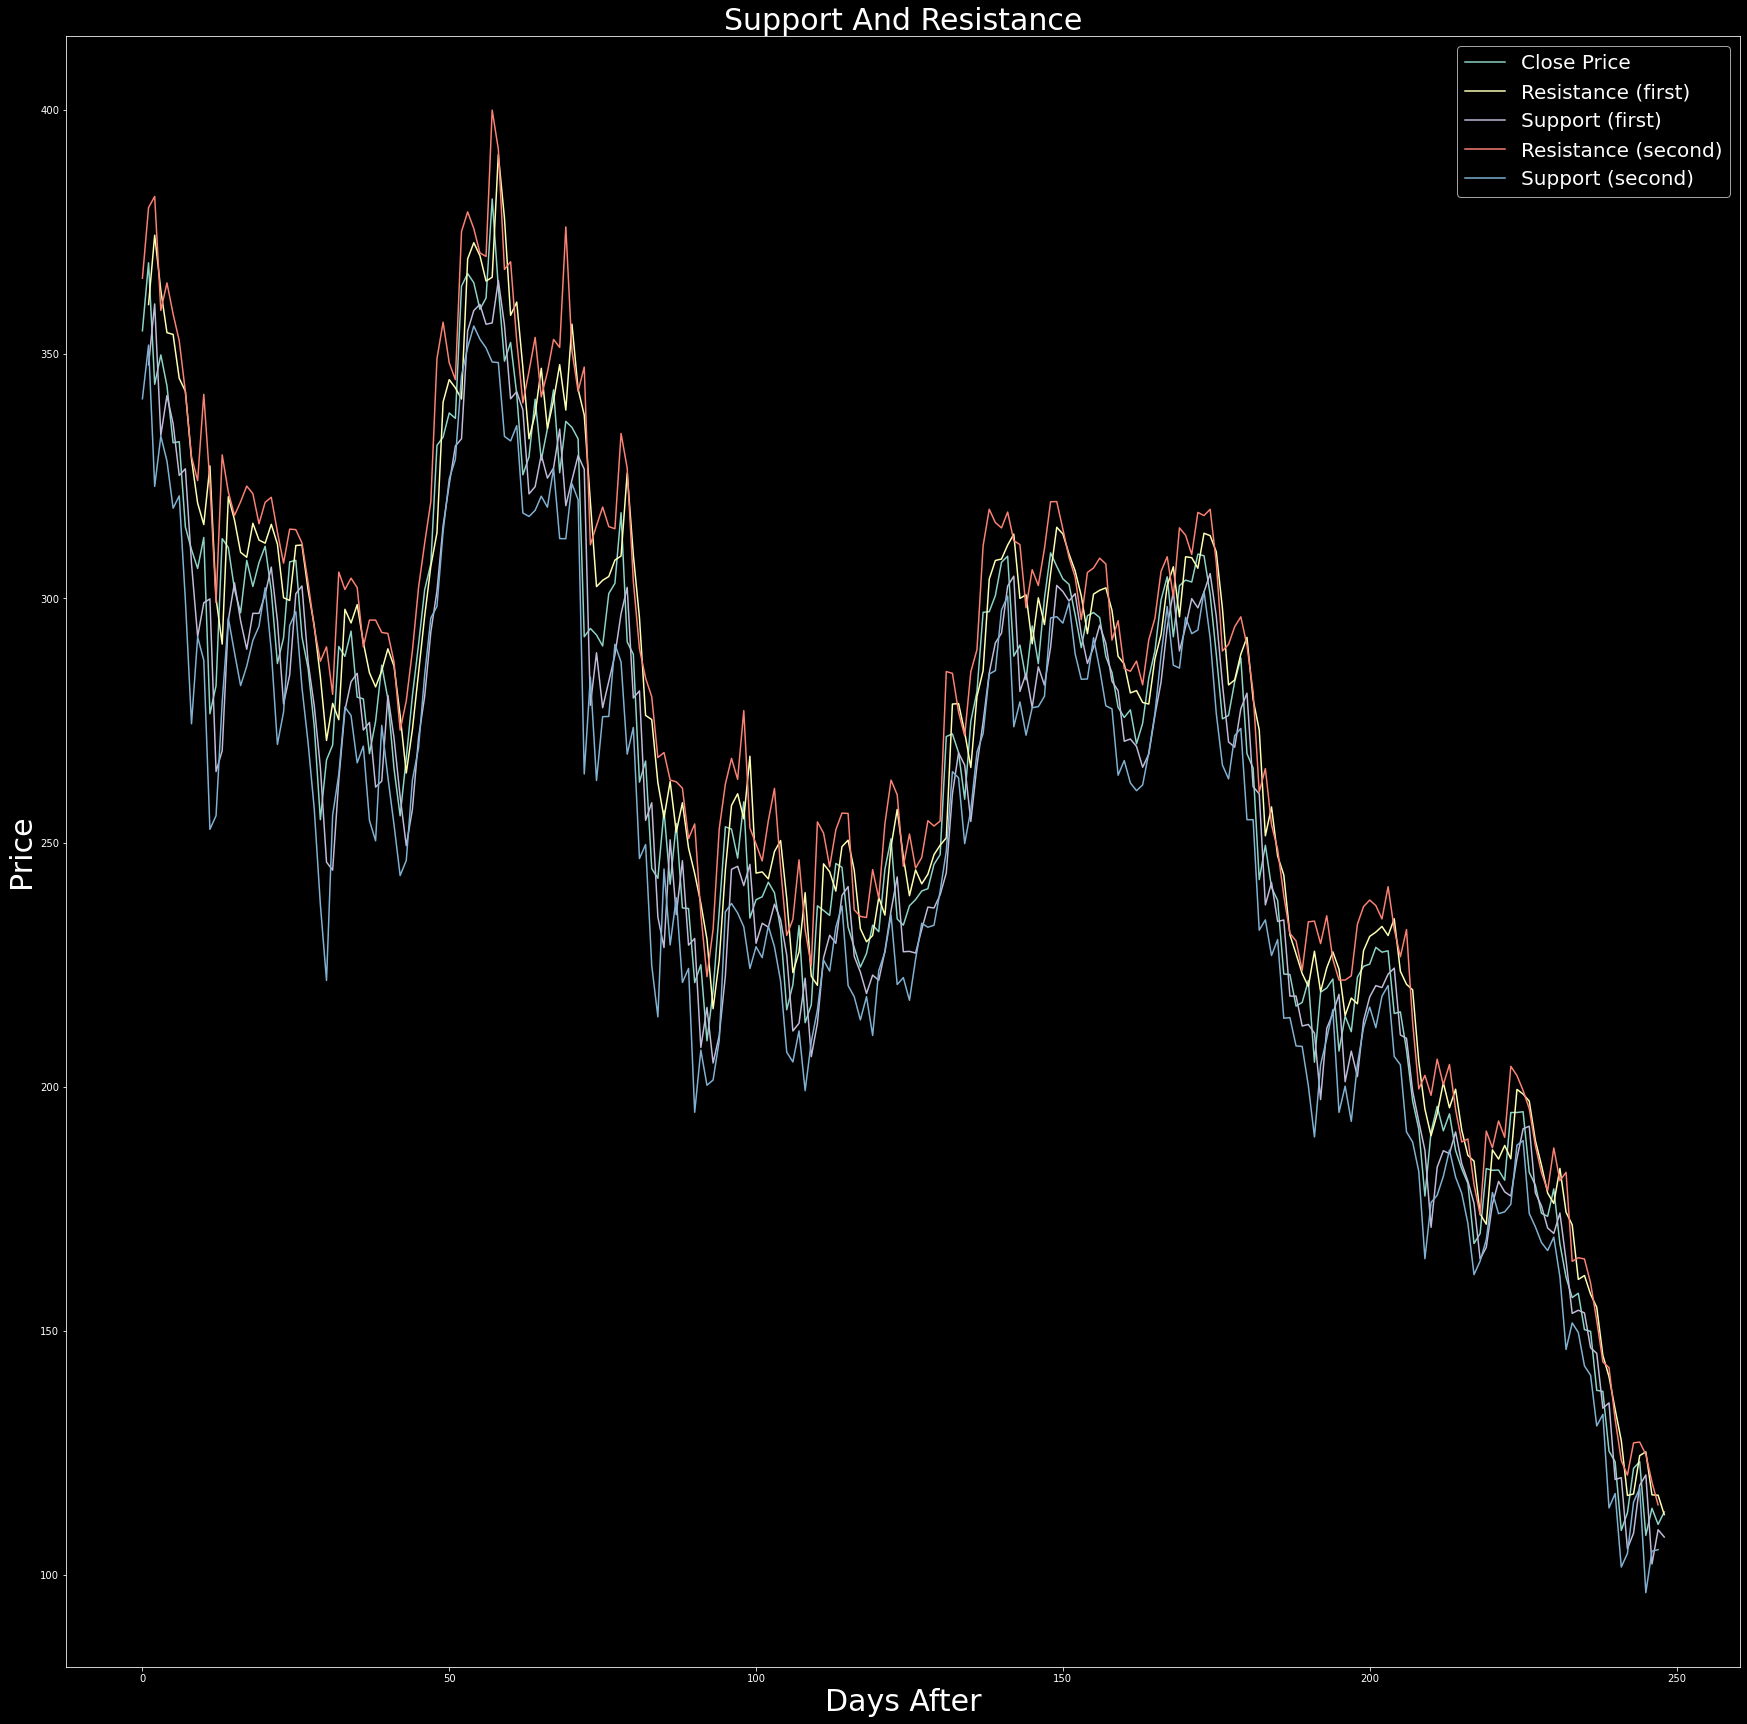

In [340]:
plt.figure(figsize=(30, 30))
plt.plot(close_prices, label='Close Price')
plt.plot(resistance_1, label='Resistance (first)')
plt.plot(support_1, label='Support (first)')
plt.plot(resistance_2, label='Resistance (second)')
plt.plot(support_2, label='Support (second)')
plt.xlabel("Days After", fontsize=30)
plt.ylabel("Price", fontsize=30)
plt.title("Support And Resistance", fontsize=30)
plt.legend(prop = {'size' : 20})
plt.savefig("graphed-results/support and resistance")
plt.show()

## Neural Network to predict the future

In [60]:
dataset = close_prices

dataset = np.array(dataset)
training = len(dataset)

In [61]:
dataset = np.reshape(dataset, (dataset.shape[0], 1))

In [62]:
dataset.shape

(249, 1)

In [63]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
print(len(train_data))
# prepare feature and labels
x_train = []
y_train = []
prediction_days = 60

for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


249


In [64]:
x_train.shape

(189, 60, 1)

## LSTM Approach

In [65]:
# RNN Using LSTMs

# SAMPLE HIGH ACCURACY MODEL
# ---------------------------------
model_rnn = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(units=75,
                    return_sequences=True,
                    input_shape=(x_train.shape[1], 1))), 
    keras.layers.Bidirectional(keras.layers.LSTM(units=64)),
    keras.layers.Dense(300),
    keras.layers.Dense(32),
    keras.layers.Dense(1),
])
# ---------------------------------


In [66]:
model_rnn.compile(optimizer='adam',
            loss='mse')
history = model_rnn.fit(x_train,
                    y_train,
                    epochs=20, 
                    batch_size=5)


Epoch 1/20
38/38 [==============================] - 11s 67ms/step - loss: 0.0238
Epoch 2/20
38/38 [==============================] - 2s 59ms/step - loss: 0.0053
Epoch 3/20
38/38 [==============================] - 3s 84ms/step - loss: 0.0055
Epoch 4/20
38/38 [==============================] - 3s 83ms/step - loss: 0.0049
Epoch 5/20
38/38 [==============================] - 3s 89ms/step - loss: 0.0046
Epoch 6/20
38/38 [==============================] - 3s 86ms/step - loss: 0.0085
Epoch 7/20
38/38 [==============================] - 4s 100ms/step - loss: 0.0043
Epoch 8/20
38/38 [==============================] - 4s 98ms/step - loss: 0.0031
Epoch 9/20
38/38 [==============================] - 4s 99ms/step - loss: 0.0036
Epoch 10/20
38/38 [==============================] - 4s 100ms/step - loss: 0.0045
Epoch 11/20
38/38 [==============================] - 4s 101ms/step - loss: 0.0031
Epoch 12/20
38/38 [==============================] - 5s 119ms/step - loss: 0.0027
Epoch 13/20
38/38 [=============

In [67]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 60, 150)          46200     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              110080    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
 dense_1 (Dense)             (None, 32)                9632      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 204,645
Trainable params: 204,645
Non-trai

In [68]:
# Only uncomment when model is better than this one (Loss < 0.0027) however higher if higher loss but 
# better predictions then change

# model_rnn.save("test-model-v1.2/")

In [69]:
test_data = scaled_data[40:]
x_test = []
y_test = []
for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])
    y_test.append(test_data[i, 0])
  
x_test = np.array(x_test)
print(x_test.shape)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model_rnn.predict(x_test)
predictions = scaler.inverse_transform(predictions)

(149, 60)
5/5 [==============================] - 4s 71ms/step


In [70]:
y_test = np.array(y_test)

In [71]:
predictions[0:5]

array([[55.48574 ],
       [55.50869 ],
       [55.50097 ],
       [55.211628],
       [55.40598 ]], dtype=float32)

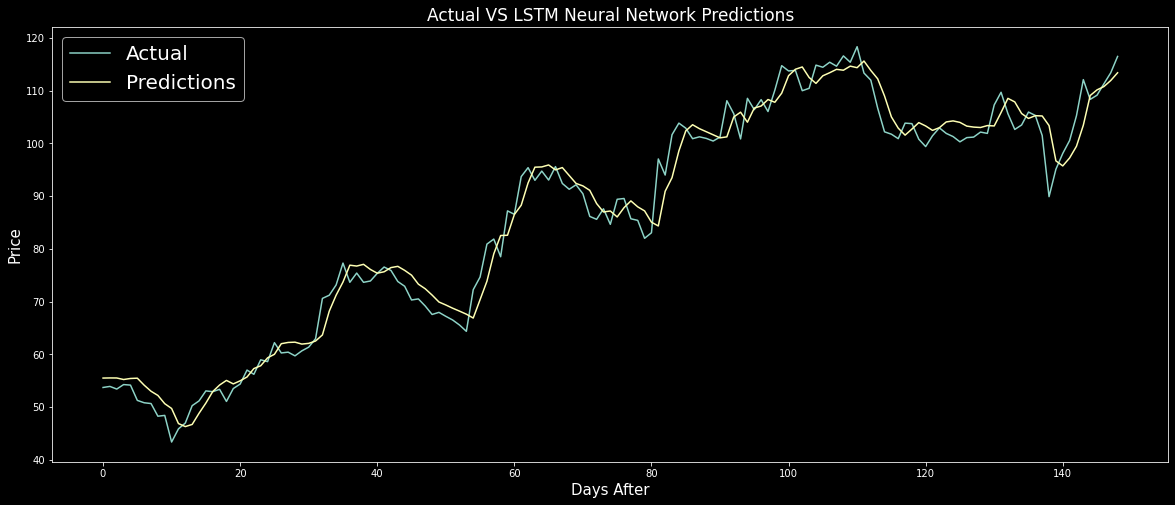

In [261]:
plt.figure(figsize=(20, 8))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual')
plt.plot(predictions, label='Predictions')
plt.title("Actual VS LSTM Neural Network Predictions", fontsize=17)
plt.xlabel("Days After", fontsize=15) 
plt.ylabel("Price", fontsize=15)
plt.legend(prop = {'size' : 20})
plt.show()

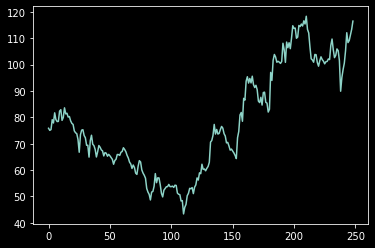

In [260]:
plt.plot(close_prices)

In [74]:
curr_price = close_prices[len(close_prices) - prediction_days:len(close_prices)]

curr_price = np.array(curr_price)
curr_price = scaler.transform(curr_price.reshape(1, -1))

In [75]:
curr_price = np.reshape(curr_price, (curr_price.shape[0], curr_price.shape[1], 1))

In [76]:
next_day_pred = model_rnn.predict(curr_price)
next_day_pred = scaler.inverse_transform(next_day_pred)

1/1 [==============================] - 0s 59ms/step


In [77]:
print(close_prices[len(close_prices) - 1])
print(next_day_pred[0][0])

116.5
115.615456


In [78]:
pred_prices = []
NUM_OF_FUTURE_DAYS = 60
tot_close_prices = list(close_prices)

# model = load_model("lstm-test-model-v1.1")
for i in range(NUM_OF_FUTURE_DAYS + 1):
    curr_price = tot_close_prices[len(tot_close_prices) - prediction_days: len(tot_close_prices)]
    curr_price = np.array(curr_price, dtype='object')
    curr_price = scaler.transform(curr_price.reshape(1, -1))
    curr_price = np.reshape(curr_price, (curr_price.shape[0], curr_price.shape[1], 1))
    next_day_pred = model_rnn.predict(curr_price)
    next_day_pred = scaler.inverse_transform(next_day_pred)
    pred_prices.append(next_day_pred)
    tot_close_prices.append(next_day_pred)
    curr_price = 0

1/1 [==============================] - 0s 61ms/step


/Users/yashsolanki/opt/anaconda3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


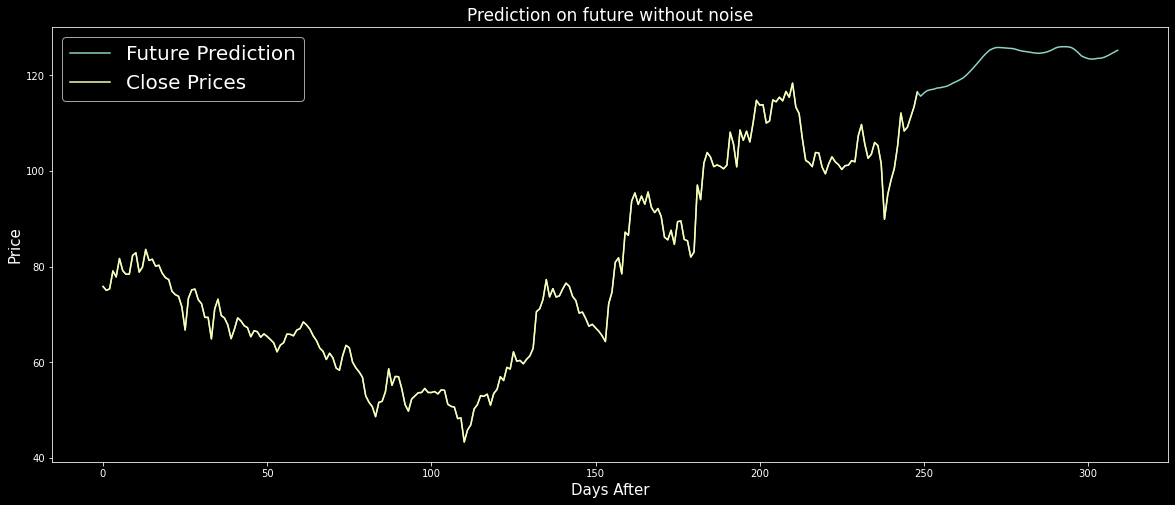

In [259]:
plt.figure(figsize=(20, 8))
plt.plot(tot_close_prices, label='Future Prediction')
plt.plot(close_prices, label='Close Prices')
plt.title("Prediction on future without noise", fontsize=17)
plt.xlabel("Days After", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.legend(prop = {'size' : 20})
plt.show()

## Computing Volitality over the prediction days period of the Stock to implement as noise

In [80]:
volitality_calc_period = 60
price_sum = 0

for i in range(len(close_prices) - volitality_calc_period, len(close_prices)):
    price_sum += close_prices[i]
    
price_avg = price_sum / volitality_calc_period

print(price_avg)

106.47249997456869


In [81]:
diffs = []

for i in range(len(close_prices) - volitality_calc_period, len(close_prices)):
    diffs.append(pow(close_prices[i] - price_avg, 2))

diffs = np.array(diffs)
diffs_sum = np.sum(diffs)

In [82]:
variance = diffs_sum / prediction_days

standard_deviation = math.sqrt(variance)

print(standard_deviation)

6.02774420260575


## Generating noise based on the standard deviation of the data over the specified period

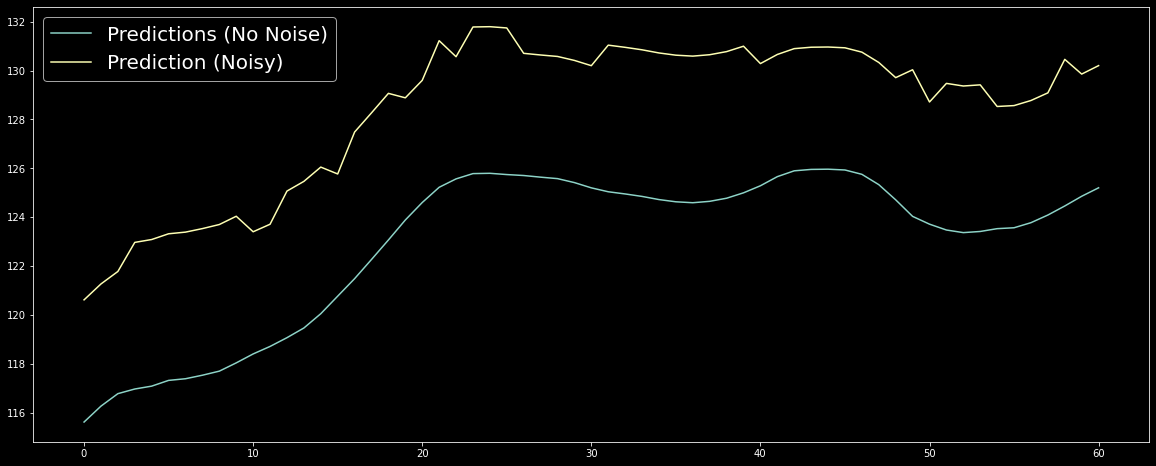

In [258]:
pred_prices_noisy = []
lower_bound = int(round(0.75 * standard_deviation))
for i in range(len(pred_prices)):
    noise = random.randint(lower_bound, round(standard_deviation))
    pred_prices_noisy.append(pred_prices[i] + noise)
    
pred_prices_noisy = np.array(pred_prices_noisy)
pred_prices_noisy = np.reshape(pred_prices_noisy, (pred_prices_noisy.shape[0]))
pred_prices = np.array(pred_prices)
pred_prices = np.reshape(pred_prices, (pred_prices.shape[0]))


plt.figure(figsize=(20, 8))
plt.plot(pred_prices, label='Predictions (No Noise)')
plt.plot(pred_prices_noisy, label='Prediction (Noisy)')
plt.legend(prop = {'size': 20})
plt.show()

## Auto trading strategy

## Strategy

### 1 :- Checking if rsi > 45 indicating a buy position. 
### 2 :- Checking if the momentum on the rsi is strong. 

In [341]:
# Adding sma for 10 and 30 days 
sma_10 = close_for_calc.rolling(10).mean().to_list()
sma_20 = close_for_calc.rolling(20).mean().to_list()
sma_30 = close_for_calc.rolling(30).mean().to_list()


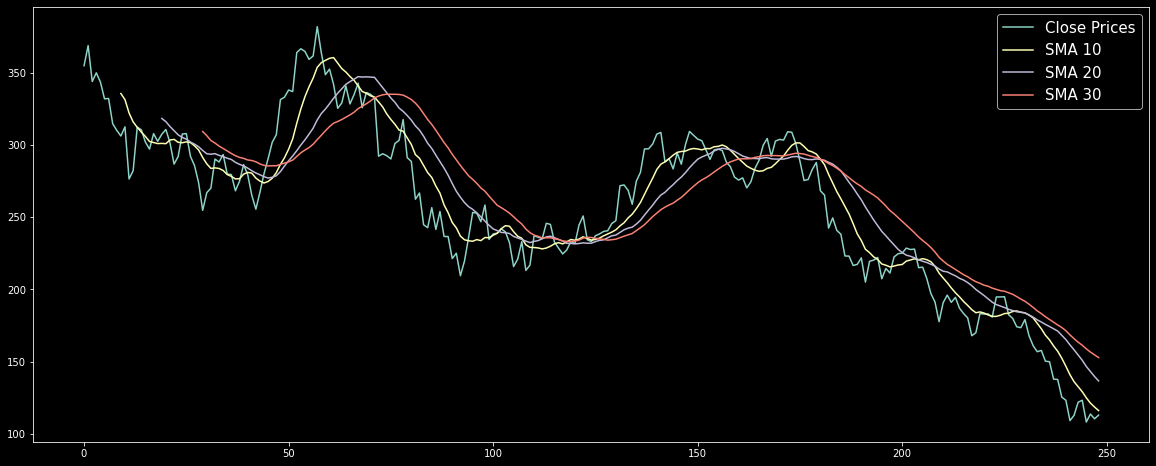

In [342]:
plt.figure(figsize=(20, 8))
plt.plot(close_prices, label='Close Prices')
plt.plot(sma_10, label='SMA 10')
plt.plot(sma_20, label='SMA 20')
plt.plot(sma_30, label='SMA 30')
plt.legend(prop={'size': 15})
plt.show()


In [343]:
# Create the data frame containing the parameters to take into account 
trade_params = pd.DataFrame(list(zip(close_prices, sma_10, sma_20, sma_30, momentum_values, relative_strength_indexs, 
                            upper_bollinger_band, lower_bollinger_band)), 
                            columns=['Close Prices', 'SMA 10', 'SMA 20', 'SMA 30', 'Momentum', 'RSI', 
                            'Upper Bollinger Band', 'Lower Bollinger Band'])


In [344]:
trade_params

,Close Prices,SMA 10,SMA 20,SMA 30,Momentum,RSI,Upper Bollinger Band,Lower Bollinger Band
0,354.799988,NaN,NaN,NaN,-42.329987,NaN,NaN,NaN
1,368.739990,NaN,NaN,NaN,-92.373322,NaN,NaN,NaN
2,343.853333,NaN,NaN,NaN,-61.736664,NaN,NaN,NaN
3,349.869995,NaN,NaN,NaN,-37.630005,NaN,NaN,NaN
4,343.503326,NaN,NaN,NaN,-33.086670,NaN,372.915028,331.391625
...,...,...,...,...,...,...,...,...
234,157.669998,172.690001,177.3625,183.166000,-34.489998,31.676447,182.931161,145.984842
235,150.229996,168.227000,175.7155,180.996666,-42.129997,28.624037,171.525551,145.862449
236,149.869995,164.969000,174.1995,179.076666,-36.229996,28.481024,164.839868,145.368127
237,137.800003,160.767000,172.6960,177.100666,-27.460007,24.128300,166.375422,134.572576


In [345]:
print(trade_params['SMA 10'].iloc[10:11])

10    331.317664
Name: SMA 10, dtype: float64


In [358]:
buy_signal = []
sell_signal = []
trigger = 0


# Currently rudimentary
for i in range(len(trade_params)):
    if (trade_params['SMA 10'].iloc[i] > trade_params['SMA 20'].iloc[i]):
        buy_signal.append(close_prices[i])
        sell_signal.append(float("nan"))
        trigger = 1

    elif (trade_params['SMA 10'].iloc[i] < trade_params['SMA 20'].iloc[i]):
        buy_signal.append(float("nan"))
        sell_signal.append(close_prices[i])
        trigger = -1

    else:
        buy_signal.append(float("nan"))
        sell_signal.append(float("nan"))    


In [359]:
trade_params['Buy Signal'] = buy_signal
trade_params['Sell Signal'] = sell_signal

In [360]:
trade_params[0:10]

,Close Prices,SMA 10,SMA 20,SMA 30,Momentum,RSI,Upper Bollinger Band,Lower Bollinger Band,Buy Signal,Sell Signal
0,354.799988,NaN,NaN,NaN,-42.329987,NaN,NaN,NaN,NaN,NaN
1,368.739990,NaN,NaN,NaN,-92.373322,NaN,NaN,NaN,NaN,NaN
2,343.853333,NaN,NaN,NaN,-61.736664,NaN,NaN,NaN,NaN,NaN
3,349.869995,NaN,NaN,NaN,-37.630005,NaN,NaN,NaN,NaN,NaN
4,343.503326,NaN,NaN,NaN,-33.086670,NaN,372.915028,331.391625,NaN,NaN
5,331.883331,NaN,NaN,NaN,-29.996674,NaN,374.586314,320.553676,NaN,NaN
6,332.089996,NaN,NaN,NaN,-35.043335,NaN,356.136497,324.343495,NaN,NaN
7,314.633331,NaN,NaN,NaN,-6.859985,NaN,361.314060,307.477932,NaN,NaN
8,310.000000,NaN,NaN,NaN,-7.553345,NaN,354.033205,298.810789,NaN,NaN
9,306.133331,335.550662,NaN,NaN,1.200012,NaN,343.502706,294.393290,NaN,NaN


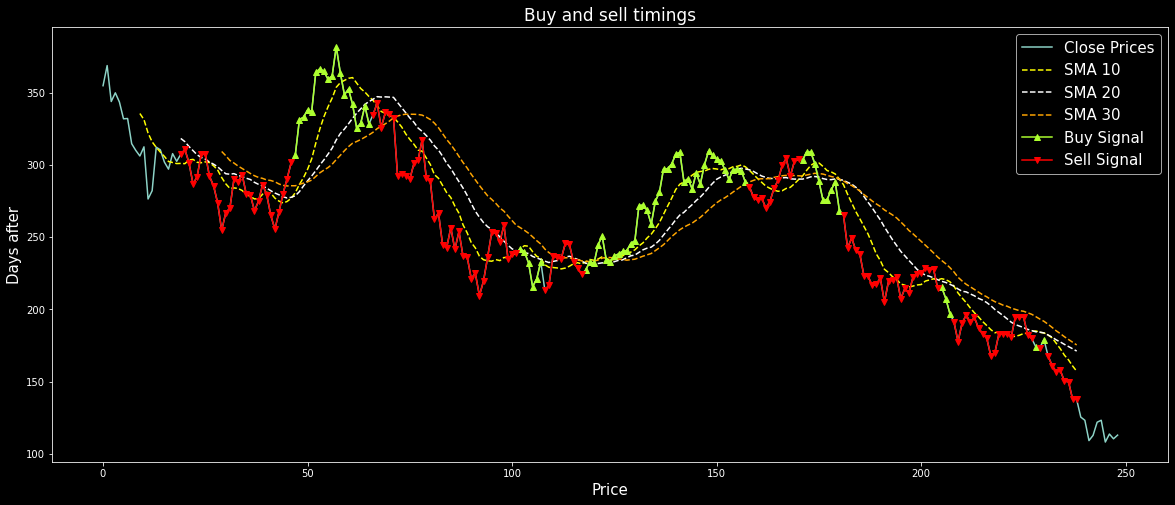

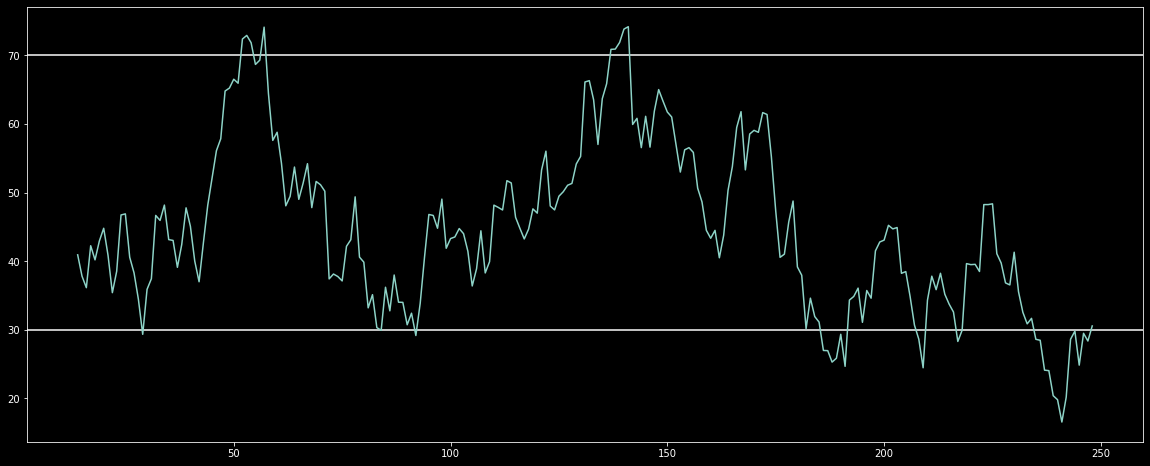

In [361]:
plt.figure(figsize=(20, 8))
plt.plot(close_prices, label='Close Prices')
plt.plot(trade_params['SMA 10'], linestyle='--', label='SMA 10', color='yellow')
plt.plot(trade_params['SMA 20'], linestyle='--',label='SMA 20', color='white')
plt.plot(trade_params['SMA 30'], linestyle='--', label='SMA 30', color='orange')
plt.plot(trade_params['Buy Signal'], marker='^', color='greenyellow', label='Buy Signal')
plt.plot(trade_params['Sell Signal'], marker='v', color='r', label='Sell Signal')
plt.legend(prop={'size': 15})
plt.title("Buy and sell timings", fontsize=17)
plt.ylabel("Days after", fontsize=15)
plt.xlabel("Price", fontsize=15)
plt.savefig("test")
plt.show()



plt.figure(figsize=(20, 8))
plt.axhline(y=30)
plt.axhline(y=70)
plt.plot(relative_strength_indexs)
plt.show()
